# Barotropic to baroclinic conversion
Following Nycander (2005) and Zilberman et al. (2009)

N.B: the current version uses TPXO7 for the tides, which is shiftef in space (by 15 km or so), resulting in anomalous values of tidal current near the islands. This has to be corrected by using TPXO8. 
TODO, compare:
 - topo from LUCKY (750m)
 - topo from SRTM30_PLUS (30'')
 - topo from TPXO8

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.usetex'] = False
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.stats as stats
from netCDF4 import Dataset
from SW_Density import SW_Density as rhop # temporary
#from comp_rho import rhop
from distance_sphere_matproof import dist_sphere_matproof
from convert_TPXO_to_ellipses import ellipse
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from change_coord import reproject_image_into_polar
#from mpi4py import MPI 
from pad_coords import pad_coords   # for padding fields outside of domain
from detrend_2d import detrend_2d
clock  = datetime.now()
import time

doverb = True


In [5]:
# --- data location ---
path_data = '/data0/project/vortex/lahaye/Tide_Conv/input_data/' #'./input_data/' #
path_data = '/net/krypton'+path_data     # if not on LOPS hub

# --- climato ---
clim = "lucky"
if clim == "lucky":
    cname = path_data+"lucky_ts_meanSODA_winter.nc"

# --- topography dataset --- 
topo = "lucky" # "tpxo" # "srtm"
if topo == 'lucky':
    file_topo = path_data+"lucky_grd.nc"
    varx, vary = 'lon_rho', 'lat_rho'
    varh = 'h'
elif topo == 'srtm':
    file_topo = TODO
    varx, vary = TODO
    varh = TODO
elif topo == 'tpxo8':
    file_topo = TODO
    varx, vary = TODO
    varh = TODO

# --- tide dataset --- 
tide = 'tpxo8' #'lucky' #

if tide == 'lucky':
    uname = path_data+'luckym2_frc.nc' 
elif tide == 'tpxo8':
    uname = "/net/ruchba/local/tmp/2/lahaye/TPXO8/uv.m2_tpxo8_atlas_30c_v1.nc"
    hname = uname.replace("uv.m2","grid")
    
zmin       = -100              # min depth to compute Ef [m], below contin. shelf roughly
g          = 9.81              # gravity [m s-2]
M2         = 2*np.pi/12.42          # M2 tide frequency [rad/hour] 
Erad = 6371e3                  # Earth radius [m]

In [26]:
# ------ get mean topo on the grid, will be used to get N2b --------
# load the entire grid (regional modelling purpose)
nc   = Dataset(file_topo,'r') # etopo2 and srtm30 files have the same structure
if topo == 'lucky':
    lon_h = nc.variables[varx][:].T
    lat_h = nc.variables[vary][:].T
    nlon_h, nlat_h = lon_h.shape
    h_t = -nc.variables[varh][:].T
    h_t[h_t>=-2.5] = 0     # land points   # "raw" topo (for FFT)
    h_ma = np.ma.masked_where(h_t==0,-h_t) # masked topo
    dx_h = 1/nc.variables['pm'][:].T
    dy_h = 1/nc.variables['pn'][:].T
    gang = nc.variables['angle'][:].T # grid angle (between xi and E, radians)
nc.close()

#dhdx = np.diff(h_t,axis=0)/0.5/(dx_h[1:,:]+dx_h[:-1,:])
#dhdx = np.r_[dhdx[:1,:]/2.,(dhdx[1:,:]+dhdx[:-1,:])/2,dhdx[-1:,:]/2.]
#dhdy = np.diff(h_t,axis=1)/0.5/(dy_h[:,1:]+dy_h[:,:-1])
#dhdy = np.c_[dhdy[:,:1]/2.,(dhdy[:,1:]+dhdy[:,:-1])/2,dhdy[:,-1:]/2.]
dhdx, dhdy = np.gradient(h_t,dx_h.mean(),dy_h.mean())

fcor = 2.*(2*np.pi/24.)*np.sin(lat_h*np.pi/180.) # coriolis, rad/hour

In [27]:
# ------ extract Tides ------------------------------

if tide == 'lucky':
    nc = Dataset(uname,'r')
    # angle between major axis and east [rad] (beware sign)
    phi = nc.variables['tide_Cangle'][0,...].T*np.pi/180.
    # tide phase ()
    pha = nc.variables['tide_Cphase'][0,...].T*np.pi/180.
    # tidal current amplitude (major, minor axes)
    ue = nc.variables['tide_Cmax'][0,...].T
    ve = nc.variables['tide_Cmin'][0,...].T
    nc.close()
elif tide == 'tpxo8':
    nch = Dataset(hname,'r')
    ncvar = nch.variables
    latu = ncvar['lat_u'][:]
    lonu = ncvar['lon_u'][:]
    #lonu[lonu>180] -= 360
    latv = ncvar['lat_v'][:]
    lonv = ncvar['lon_v'][:]
    #lonv[lonv>180] -= 360
    indxu, = np.where( (lonu>=(lon_h%360).min()) & (lonu<=(lon_h%360).max()) )
    indxv, = np.where( (lonv>=(lon_h%360).min()) & (lonv<=(lon_h%360).max()) )
    indyu, = np.where( (latu>=lat_h.min()) & (latu<=lat_h.max()) )
    indyv, = np.where( (latv>=lat_h.min()) & (latv<=lat_h.max()) )
    hu = ncvar['hu'][indxu,indyu]
    hv = ncvar['hv'][indxv,indyv]
    nch.close()
    nc = Dataset(uname,'r')
    ncvar = nc.variables
    ure = ncvar['uRe'][indxu,indyu]*1e-4/hu    # cm²/s to m²/s
    vre = ncvar['vRe'][indxv,indyv]*1e-4/hv
    uim = ncvar['uIm'][indxu,indyu]*1e-4/hu
    vim = ncvar['vIm'][indxv,indyv]*1e-4/hv  
    del hu, hv
    nc.close()

# conversion to grid coordinates
if tide == 'lucky':
    ubt = ue*np.cos(phi-gang)*np.cos(pha) - ve*np.sin(phi-gang)*np.sin(pha)
    vbt = ue*np.sin(phi-gang)*np.cos(pha) + ve*np.cos(phi-gang)*np.sin(pha)
elif tide == 'tpxo8':
    # interpolate on h_grid
    #ure = itp.griddata((np.ravel(lonu),np.ravel(latu)),np.ravel(ua_tmp),(lon2d,lat2d)
    ure = interp.RectBivariateSpline(lonu[indxu], latu[indyu], np.nan_to_num(ure)).ev(lon_h%360,lat_h%360)
    vre = interp.RectBivariateSpline(lonv[indxv], latv[indyv], np.nan_to_num(vre)).ev(lon_h%360,lat_h%360)
    uim = interp.RectBivariateSpline(lonu[indxu], latu[indyu], np.nan_to_num(uim)).ev(lon_h%360,lat_h%360)
    vim = interp.RectBivariateSpline(lonv[indxv], latv[indyv], np.nan_to_num(vim)).ev(lon_h%360,lat_h%360)
    pha = np.arctan2(-vim,vre) - np.arctan2(-uim,ure)
    ua = np.abs(ure + 1j*uim)    
    va = np.abs(vre + 1j*vim)
        
    ubt = ua*np.cos(gang) + va*np.sin(gang)
    vbt = -ua*np.sin(gang) + va*np.cos(gang)
    del ure, vre, uim, vim, ua, va

In [9]:
# ------ extract density profile, compute N2 ------------------
if clim == "lucky":
    nc = Dataset(cname,'r')
    T = nc.variables['temp_roms_avg'][:]
    S = nc.variables['salt_roms_avg'][:]
    zz = nc.variables['depth'][:]
    nz = zz.size
    
rho = np.sort(rhop(T,S)) #SW_Density(T,S) # sorting is cheating here
rho0 = rho.mean()
frho = interp.pchip(zz[::-1],rho[::-1],extrapolate=True)
N2_tmp = -(g/rho0)*frho.derivative()(zz)    # take routine
# temporary fixing:
if N2_tmp[-1]==0: N2_tmp[-1] = 1e-8
indneg, = np.where(N2_tmp<=0.)
for ii in indneg:
    N2_tmp[ii] = (N2_tmp[ii-1] + N2_tmp[ii+1])/2
fN2 = interp.pchip(zz[::-1],N2_tmp,extrapolate=True)    


# fit exponential profile
slope,intercept,r_val,p_val,std_err = stats.linregress(zz,np.log(N2_tmp**0.5))
N0  = np.exp(intercept)
b   = 1./slope
Nb = np.sqrt(fN2(h_t))

if doverb:
    if indneg.size>0:
        print('had to resort stratif for {} values'.format(indneg.size))
    print('exponential interpolation for stratification: N0={0}, b={1}'.format(N0,b))
    
coef = rho0*Nb/2*np.sqrt(1-fcor**2/M2**2)
kn = lambda n: np.sqrt(M2**2-fcor**2)*n*np.pi/N0/h_ma/3600. # should be bar(N)
kone = np.nanmean(kn(1))
print('1st mode mean hor. wavelength: {} km'.format(2*np.pi/kone/1e3))

exponential interpolation for stratification: N0=0.0029670034109957793, b=1472.7289614711046
1st mode mean hor. wavelength: 124.39625347468572 km


In [10]:
def spe_filt(kk,kone=1.,fmod='heavy'):
    if fmod == 'heavy':
        return (kk>kone).astype(float)
    elif fmod is None:
        return np.ones(kk.shape)

In [19]:
### go for it -- this version valid for LUCKY topo
dowin = False
npad = 500

if doverb:
    tmes, tmeb = time.clock(), time.time()

if npad > 0:
    h = np.pad(h_t,npad,'edge')
else:
    h = h_t.copy()
#h = detrend_2d(h) # apply bilinear detrend
nx, ny = h.shape
dxi, dyi = dx_h.mean(), dy_h.mean()
kx = np.fft.fftfreq(nx,dxi)*2*np.pi    # wavenumbers in x-direction = major axis
ky = np.fft.fftfreq(ny,dyi)*2*np.pi    # wavenumbers in x-direction = major axis
dkx, dky = kx[1]-kx[0], ky[1]-ky[0]
modk = np.sqrt(kx[:,None]**2 + ky[None,:]**2)
if dowin:
    win_x = np.hanning(nx)[None,:]  # window before filtering 
    win_y = np.hanning(ny)[:,None]
else:
    win_x = np.ones((1,nx))
    win_y = np.ones((ny,1))
win = np.dot(win_y,win_x)
int_rec = nx*ny             # integral of a squared rectangular window (as if no windowing) 
int_win = np.nansum(win**2) # integral of the squared window 
norm    = (int_rec/int_win)*1/(nx*ny*dkx*dky) # [1/(rad m-1)^2] normalization constant 
if doverb:
    print('ready for FFT',time.clock()-tmes,time.time()-tmeb)
    tmes, tmeb = time.clock(), time.time()
tfh = np.fft.fft2(h*win)
if doverb:
    print('FFT done',time.clock()-tmes,time.time()-tmeb)
    tmes, tmeb = time.clock(), time.time()

# TODO add spectral filter and compute modified ifft2
modl = 1./modk
modl[modk==0.] = 0.
#sdxh = np.fft.ifft2(1j*kx[:,None]*modl*tfh).real
#sdyh = np.fft.ifft2(1j*ky[None,:]*modl*tfh).real
sdxh = np.fft.ifft2(1j*kx[:,None]*spe_filt(modk,kone)*modl*tfh).real
sdyh = np.fft.ifft2(1j*ky[None,:]*spe_filt(modk,kone)*modl*tfh).real
#sdxh = np.fft.ifft2(1j*kx[:,None]*spe_filt(modk,kone)*tfh).real
#sdyh = np.fft.ifft2(1j*ky[None,:]*spe_filt(modk,kone)*tfh).real
if npad > 0:
    sdxh = sdxh[npad:-npad,npad:-npad]
    sdyh = sdyh[npad:-npad,npad:-npad]
if doverb:
    print('inv. FFTs done',time.clock()-tmes,time.time()-tmeb)

P_pos = coef*dhdx*(ubt**2*sdxh + ubt*vbt*np.cos(pha)*sdyh)
P_neg = coef*dhdy*(vbt**2*sdyh + ubt*vbt*np.cos(pha)*sdxh)
C_t = P_pos + P_neg

ready for FFT 0.632680999999991 0.19163107872009277
FFT done 1.967495999999997 1.730903148651123
inv. FFTs done 3.886173999999997 3.8843026161193848


In [1]:
mini, maxi = np.array([-1,1])*1.
#mini, maxi = np.array([-1,1])*2.5e3
toplot = C_t

fig = plt.figure(figsize=(9,8))
#plt.pcolormesh(lon_h.T,lat_h.T,toplot.T,cmap='seismic')
plt.pcolormesh(lon_h.T,lat_h.T,toplot.T,cmap='seismic',vmin=mini,vmax=maxi)
plt.colorbar()
plt.grid(True)

ubt.mean(), vbt.mean()
#np.isfinite(modk).all()

NameError: name 'np' is not defined

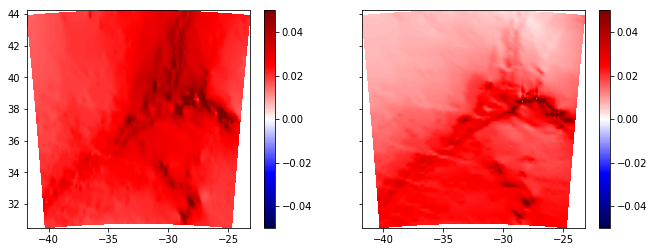

In [28]:
#plt.pcolormesh(h*win)
mini, maxi = np.array([-1,1])*.05

fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(11,4))
hpm = ax1.pcolormesh(lon_h.T,lat_h.T,ubt.T,cmap='seismic',vmin=mini,vmax=maxi)
plt.colorbar(hpm,ax=ax1)
hpm = ax2.pcolormesh(lon_h.T,lat_h.T,vbt.T,cmap='seismic',vmin=mini,vmax=maxi)
plt.colorbar(hpm,ax=ax2)

In [31]:
gang.min(), gang.max()

(-0.0012512334192851941, 0.0012512334192851941)

(-8.1916083470114223e-05, 0.020760202753804542)

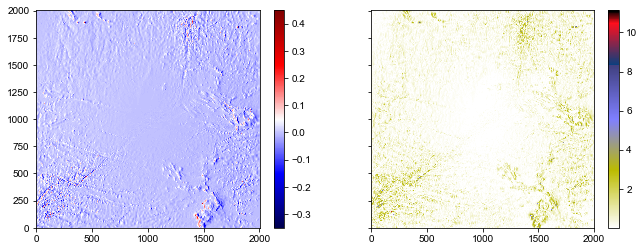

In [137]:
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(11,4))
hpm = ax1.pcolormesh((dhdx-sdxh).T,cmap='seismic')
plt.colorbar(hpm,ax=ax1)
hpm = ax2.pcolormesh(np.abs(dhdx-sdxh).T/dhdx.std(),cmap='gist_stern_r')
plt.colorbar(hpm,ax=ax2)

(dhdx-sdxh).mean(), (dhdx-sdxh).std()

(0.997766381623-0.000687148128711j)


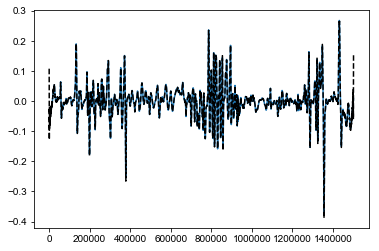

In [60]:
## OK for 1D differentiation, although I'm not sure how to normalize the results

ind = 1001

yy = h[:,ind]
xx = np.cumsum(dx_h[:,ind])
xdif = 0.5*(xx[1:] + xx[:-1])

Nx = len(xx)
dx = xx[1] - xx[0]

kx = np.fft.fftfreq(Nx,dx)*2*np.pi
tfh = np.fft.fft(yy)
sdh = np.fft.ifft(1j*kx*tfh)
dy = np.diff(yy)/dx

print(dy.max()/sdh.max())

plt.plot(xdif,dy,xx,sdh,'--k')